In [1]:
print(0)

0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

In [9]:
class Config:
    DATA_PATH = Path("./data/film_indonesia.csv")
    PICKLE_PATH =  Path("./pickle")
    FEATURES = ["judul_film", "ringkasan_sinopsis"]
    LABEL = "genre"
    
class Metric:
    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
    
    def precision(self, y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        return tp / (tp + fp)
    
    def recall(self, y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        return tp / (tp + fn)
    
    def f1_score(self, y_true, y_pred):
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * precision * recall / (precision + recall)
    
    def classification_metrics(self, y_true, y_pred):
        accuracy = self.accuracy(y_true, y_pred)
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(y_true, y_pred)
        return accuracy, precision, recall, f1_score


class KFold:
    def __init__(self, n_splits=5, shuffle=True):
        self.n_splits = n_splits
        self.shuffle = shuffle
    
    def split(self, X):
        n = len(X)
        idx = np.arange(n)
        
        if self.shuffle:
            np.random.shuffle(idx)
        
        for i in range(self.n_splits):
            start = i * n // self.n_splits
            end = (i + 1) * n // self.n_splits
            val_idx = idx[start:end]
            train_idx = np.delete(idx, val_idx)
            yield train_idx, val_idx


class MKNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def _cosine_similarity(self, x1, x2):
        return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

    def _S(self, a, b):
        return 1 if a == b else 0
    
    def _validity_score(self, i):
        distances = np.array([self._cosine_similarity(self.X_train[i], x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        return 1 / self.k * np.sum([self._S(self.y_train[i], self.y_train[k]) for k in k_indices])
        
    def _predict(self, x_test):
        distances = np.array([self._cosine_similarity(x_test, x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        validity_scores = [self._validity_score(i) for i in k_indices]
        k_labels=  [self.y_train[i] for i in k_indices]

        W = [
            validity_scores[i] / (distances[k_indices[i]] + 0.0001) for i in range(len(k_indices))
        ]

        sum_w = Counter()
        for i in range(len(k_indices)):
            sum_w[k_labels[i]] += W[i]
        
        return sum_w.most_common(1)[0][0]
        
    def predict(self, X_test):
        return np.array([self._predict(x_test) for x_test in X_test])
    
class Tfidfvectorizer:
    def __init__(self, min_df=1):
        self.min_df = min_df
    
    def preprocess(self, docs):
        self.word_set = []
        self.kalimats = []
        
        for kalimat in docs:
            kalimat = [kata.lower() for kata in kalimat.split()]
            self.kalimats.append(kalimat)
            for kata in kalimat:
                if kata not in self.word_set:
                    self.word_set.append(kata)
        
        self.word_set = set(self.word_set)
        self.n_docs = len(self.kalimats)
        self.index_dict = {kata: i for i, kata in enumerate(self.word_set)}
        
        self.word_count = {}
        for kata in self.word_set:
            self.word_count[kata] = 0
            for kalimat in self.kalimats:
                if kata in kalimat:
                    self.word_count[kata] += 1


    def tf(self,docs, kata):
        n = len(docs)
        cocok = len([k for k in docs if k == kata])
        return cocok / n
    
    def idf(self,kata):
        try:
            kata_cocok = self.word_count[kata] + 1
        except:
            kata_cocok = 1
        
        return np.log(self.n_docs / kata_cocok)
    
    def tf_idf(self, kalimat):
        vec = np.zeros((len(self.word_set),))
        for kata in kalimat:
            tf = self.tf(kalimat, kata)
            idf = self.idf(kata)
            
            vec[self.index_dict[kata]] = tf * idf
        
        return vec

    def fit_transform(self, docs):
        self.preprocess(docs)
        vecs = []
        for kalimat in self.kalimats:
            vecs.append(self.tf_idf(kalimat))
        
        return np.array(vecs)


class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, p=2):
        predicted_labels = [self._predict(x, p) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x, p=2):
        distances = [self._distance(x, x_train, p) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _distance(self, x1, x2, p=2):
        return np.sum((x1 - x2) ** p) ** (1 / p)

    def score(self, X, y):
        predicted_labels = self.predict(X)
        return np.mean(predicted_labels == y)


In [86]:
data = pd.read_csv(Config.DATA_PATH)
data["genre"].value_counts()

genre
Laga      202
Komedi    201
Name: count, dtype: int64

<BarContainer object of 2 artists>

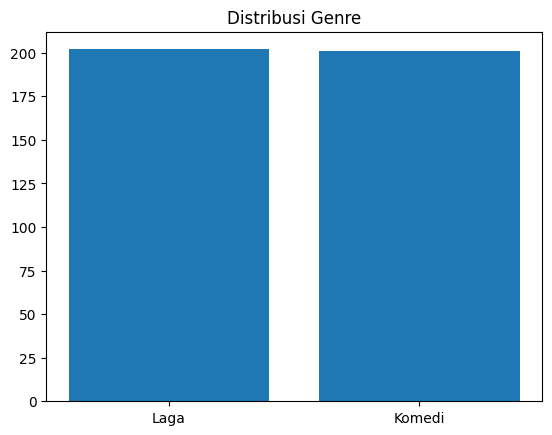

In [90]:
plt.title("Distribusi Genre")
plt.bar(data["genre"].value_counts().index, data["genre"].value_counts().values)

In [91]:
data.shape

(403, 3)

## Text Preprocessing

In [74]:
import re

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: x.lower())
data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data["judul_film"] = data["judul_film"].apply(lambda x: x.lower())
data["judul_film"] = data["judul_film"].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data.head()

,judul_film,ringkasan_sinopsis,genre
0,warkop dki reborn jangkrik boss,dono abimana aryasatya kasino vino g bastian d...,Komedi
1,garuda 7 next mission,film ini menceritakan mengenai pemain sepakbol...,Komedi
2,si pitung,pitung bak koboi yang menyelesaikan satu masal...,Komedi
3,pangolin,pangolin adalah pandangan sekilas ke dalam per...,Komedi
4,hafiz friends recap s3,bercerita tentang pertualangan hafiz dan teman...,Komedi


In [75]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: stemmer.stem(x))
data["judul_film"] = data["judul_film"].apply(lambda x: stemmer.stem(x))

In [76]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory_stopword = StopWordRemoverFactory()
sw = factory_stopword.create_stop_word_remover()

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: sw.remove(x))
data["judul_film"] = data["judul_film"].apply(lambda x: sw.remove(x))

In [77]:
data.head()

,judul_film,ringkasan_sinopsis,genre
0,warkop dki reborn jangkrik boss,dono abimana aryasatya kasino vino bastian ind...,Komedi
1,garuda 7 next mission,film cerita main sepakbola indonesia nasional ...,Komedi
2,si pitung,pitung bak koboi selesai pergi si pitung dicky...,Komedi
3,pangolin,pangolin pandang kilas jalan trenggiling tungg...,Komedi
4,hafiz friends recap s3,cerita tualang hafiz teman tema,Komedi


## Training

In [78]:
kf = KFold(n_splits=5)

for train_idx, test_idx in kf.split(data[Config.FEATURES]):
    print(len(train_idx), len(test_idx))
    # print(data[Config.LABEL][train_idx].value_counts())
    break

323 80


In [79]:
t = Tfidfvectorizer()

X_ringkasan = t.fit_transform(data["ringkasan_sinopsis"])
X_judul = t.fit_transform(data["judul_film"])
y = np.array(data[Config.LABEL].replace({"Komedi": 0, "Laga": 1}))

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

X = np.concatenate([X_ringkasan, X_judul], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
metric = Metric()
ks = range(2, 20)
mknn_f1_score_list = []
mknn_precision_list = []
mknn_recall_list = []
mknn_accuracy_list = []
knn_f1_score_list = []
knn_precision_list = []
knn_recall_list = []
knn_accuracy_list = []

for i in tqdm(ks):
    mk = MKNNClassifier(k=i)
    mk.fit(X_train, y_train)
    y_pred = mk.predict(X_test)
    
    kk = KNNClassifier(k=i)
    kk.fit(X_train, y_train)
    y_pred_knn = kk.predict(X_test)
    
    mknn_accuracy, mknn_precision, mknn_recall, mknn_f1_score = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
    knn_accuracy, knn_precision, knn_recall, knn_f1_score = accuracy_score(y_test, y_pred_knn), precision_score(y_test, y_pred_knn), recall_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn)

    
    mknn_f1_score_list.append(mknn_f1_score)
    mknn_precision_list.append(mknn_precision)
    mknn_recall_list.append(mknn_recall)
    mknn_accuracy_list.append(mknn_accuracy)
    
    knn_f1_score_list.append(knn_f1_score)
    knn_precision_list.append(knn_precision)
    knn_recall_list.append(knn_recall)
    knn_accuracy_list.append(knn_accuracy)

100%|██████████| 18/18 [01:18<00:00,  4.38s/it]


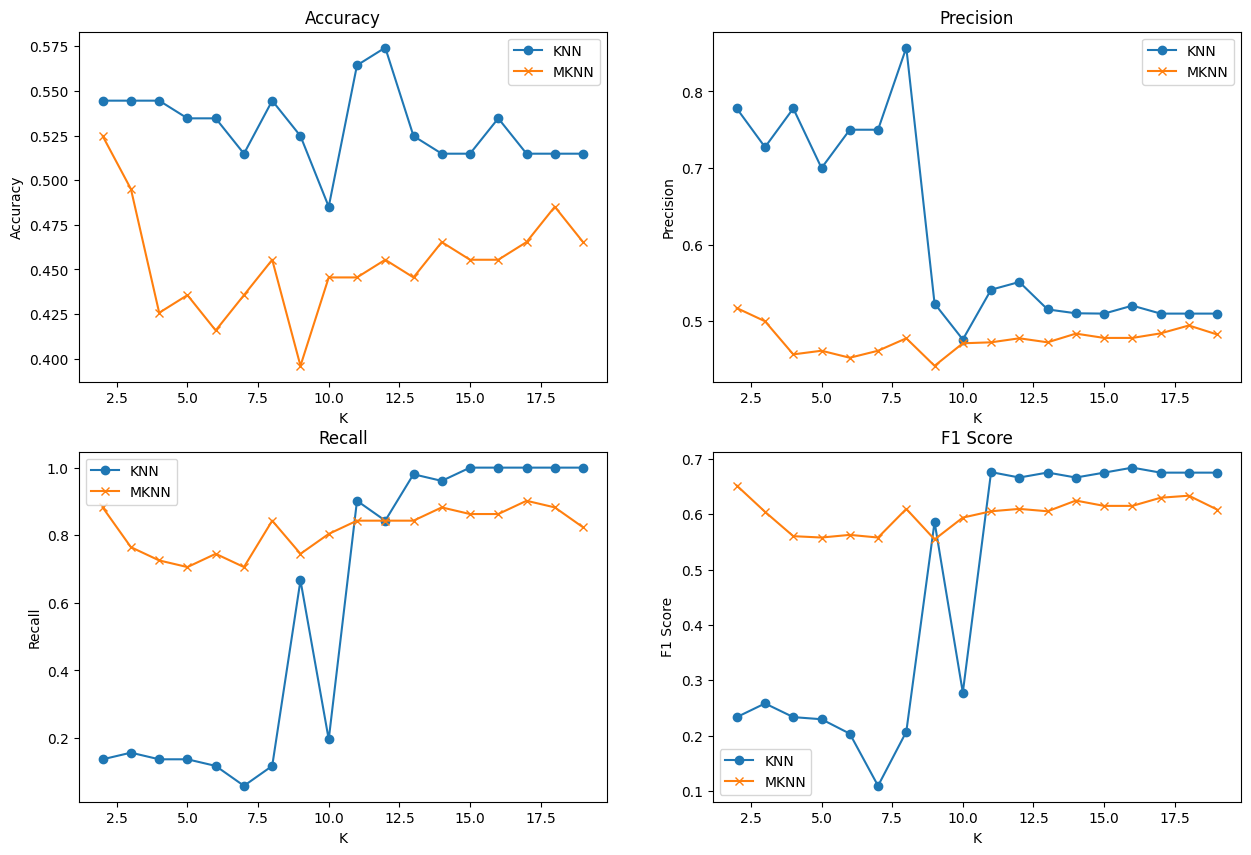

In [81]:
knn_acc_dict = dict(zip(ks, knn_accuracy_list))
knn_precision_dict = dict(zip(ks, knn_precision_list))
knn_recall_dict = dict(zip(ks, knn_recall_list))
knn_f1_score_dict = dict(zip(ks, knn_f1_score_list))

mknn_acc_dict = dict(zip(ks, mknn_accuracy_list))
mknn_precision_dict = dict(zip(ks, mknn_precision_list))
mknn_recall_dict = dict(zip(ks, mknn_recall_list))
mknn_f1_score_dict = dict(zip(ks, mknn_f1_score_list))


plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title("Accuracy")
plt.plot(knn_acc_dict.keys(), knn_acc_dict.values(), label="KNN", marker="o")
plt.plot(mknn_acc_dict.keys(), mknn_acc_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Precision")
plt.plot(knn_precision_dict.keys(),
         knn_precision_dict.values(), label="KNN", marker="o")
plt.plot(mknn_precision_dict.keys(),
         mknn_precision_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Recall")
plt.plot(knn_recall_dict.keys(), knn_recall_dict.values(),
         label="KNN", marker="o")
plt.plot(mknn_recall_dict.keys(), mknn_recall_dict.values(),
         label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("F1 Score")
plt.plot(knn_f1_score_dict.keys(),
         knn_f1_score_dict.values(), label="KNN", marker="o")
plt.plot(mknn_f1_score_dict.keys(),
         mknn_f1_score_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("F1 Score")
plt.legend()

plt.show()

In [82]:
best_f1_score_knn = np.argmax(list(knn_f1_score_dict.values())) + 2
best_f1_score_mknn = np.argmax(list(mknn_f1_score_dict.values())) + 2
best_acc_knn = np.argmax(list(knn_acc_dict.values())) + 2
best_acc_mknn = np.argmax(list(mknn_acc_dict.values())) + 2
best_precision_knn = np.argmax(list(knn_precision_dict.values())) + 2
best_precision_mknn = np.argmax(list(mknn_precision_dict.values())) + 2
best_recall_knn = np.argmax(list(knn_recall_dict.values())) + 2
best_recall_mknn = np.argmax(list(mknn_recall_dict.values())) + 2

pd.DataFrame({
    "metrics": ["F1 Score", "Accuracy", "Precision", "Recall"],
    "KNN": [
            (knn_f1_score_dict[best_f1_score_knn], best_f1_score_knn),
            (knn_acc_dict[best_acc_knn], best_acc_knn),
            (knn_precision_dict[best_precision_knn], best_precision_knn),
            (knn_recall_dict[best_recall_knn], best_recall_knn)
    ],
    "MKNN": [
        (mknn_f1_score_dict[best_f1_score_mknn], best_f1_score_mknn),
        (mknn_acc_dict[best_acc_mknn], best_acc_mknn),
        (mknn_precision_dict[best_precision_mknn], best_precision_mknn),
        (mknn_recall_dict[best_recall_mknn], best_recall_mknn)
    ]
})

,metrics,KNN,MKNN
0,F1 Score,"(0.6845637583892618, 16)","(0.6521739130434783, 2)"
1,Accuracy,"(0.5742574257425742, 12)","(0.5247524752475248, 2)"
2,Precision,"(0.8571428571428571, 8)","(0.5172413793103449, 2)"
3,Recall,"(1.0, 15)","(0.9019607843137255, 17)"


In [21]:
knn_df = pd.DataFrame({
    "k": knn_acc_dict.keys(),
    "accuracy": knn_acc_dict.values(),
    "precision": knn_precision_dict.values(),
    "recall": knn_recall_dict.values(),
    "f1_score": knn_f1_score_dict.values(),
})

mknn_df = pd.DataFrame({
    "k": mknn_acc_dict.keys(),
    "accuracy": mknn_acc_dict.values(),
    "precision": mknn_precision_dict.values(),
    "recall": mknn_recall_dict.values(),
    "f1_score": mknn_f1_score_dict.values(),
})

In [22]:
knn_df.to_csv("./data/scores/2005_knn scores_2.csv", index=False)
mknn_df.to_csv("./data/scores/2005_mknn scores_2.csv", index=False)

## ablation study

tanpa stopword

In [47]:
data = pd.read_csv(Config.DATA_PATH)
data["genre"].value_counts()
# Text Preprocessing

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: x.lower())
data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data["judul_film"] = data["judul_film"].apply(lambda x: x.lower())
data["judul_film"] = data["judul_film"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data.head()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: stemmer.stem(x))
data["judul_film"] = data["judul_film"].apply(lambda x: stemmer.stem(x))

# factory_stopword = StopWordRemoverFactory()
# sw = factory_stopword.create_stop_word_remover()

# data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
#     lambda x: sw.remove(x))
# data["judul_film"] = data["judul_film"].apply(lambda x: sw.remove(x))

# Training
t = Tfidfvectorizer()

X_ringkasan = t.fit_transform(data["ringkasan_sinopsis"])
X_judul = t.fit_transform(data["judul_film"])
y = np.array(data[Config.LABEL].replace({"Komedi": 0, "Laga": 1}))

X = np.concatenate([X_ringkasan, X_judul], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
metric = Metric()
ks = range(2, 20)
mknn_f1_score_list = []
mknn_precision_list = []
mknn_recall_list = []
mknn_accuracy_list = []
knn_f1_score_list = []
knn_precision_list = []
knn_recall_list = []
knn_accuracy_list = []

for i in tqdm(ks):
    mk = MKNNClassifier(k=i)
    mk.fit(X_train, y_train)
    y_pred = mk.predict(X_test)

    kk = KNNClassifier(k=i)
    kk.fit(X_train, y_train)
    y_pred_knn = kk.predict(X_test)

    mknn_accuracy, mknn_precision, mknn_recall, mknn_f1_score = accuracy_score(
        y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
    knn_accuracy, knn_precision, knn_recall, knn_f1_score = accuracy_score(y_test, y_pred_knn), precision_score(
        y_test, y_pred_knn), recall_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn)

    mknn_f1_score_list.append(mknn_f1_score)
    mknn_precision_list.append(mknn_precision)
    mknn_recall_list.append(mknn_recall)
    mknn_accuracy_list.append(mknn_accuracy)

    knn_f1_score_list.append(knn_f1_score)
    knn_precision_list.append(knn_precision)
    knn_recall_list.append(knn_recall)
    knn_accuracy_list.append(knn_accuracy)
knn_acc_dict = dict(zip(ks, knn_accuracy_list))
knn_precision_dict = dict(zip(ks, knn_precision_list))
knn_recall_dict = dict(zip(ks, knn_recall_list))
knn_f1_score_dict = dict(zip(ks, knn_f1_score_list))

mknn_acc_dict = dict(zip(ks, mknn_accuracy_list))
mknn_precision_dict = dict(zip(ks, mknn_precision_list))
mknn_recall_dict = dict(zip(ks, mknn_recall_list))
mknn_f1_score_dict = dict(zip(ks, mknn_f1_score_list))

323 80


100%|██████████| 18/18 [01:22<00:00,  4.57s/it]


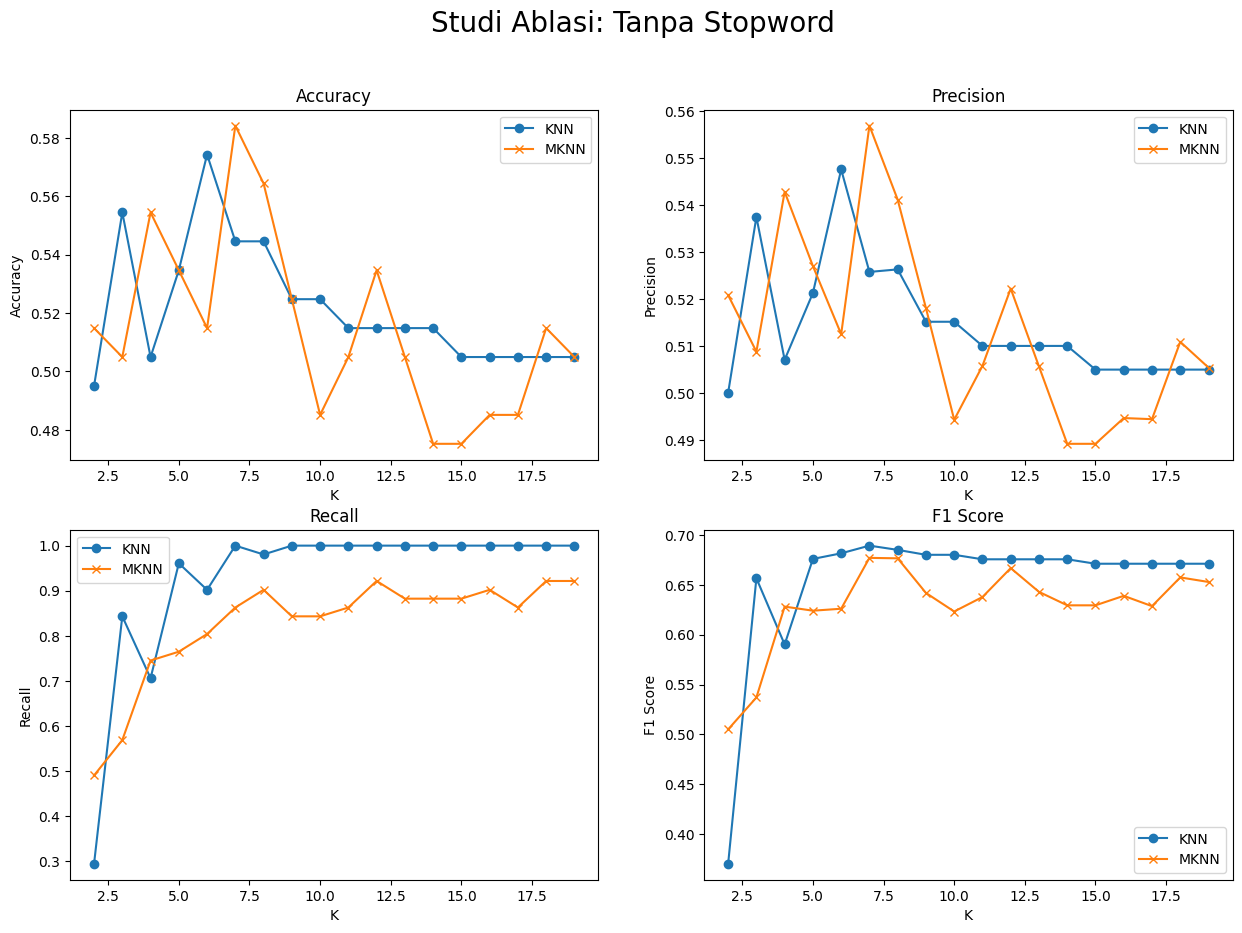

In [48]:
plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title("Accuracy")
plt.plot(knn_acc_dict.keys(), knn_acc_dict.values(), label="KNN", marker="o")
plt.plot(mknn_acc_dict.keys(), mknn_acc_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Precision")
plt.plot(knn_precision_dict.keys(),
         knn_precision_dict.values(), label="KNN", marker="o")
plt.plot(mknn_precision_dict.keys(),
         mknn_precision_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Recall")
plt.plot(knn_recall_dict.keys(), knn_recall_dict.values(),
         label="KNN", marker="o")
plt.plot(mknn_recall_dict.keys(), mknn_recall_dict.values(),
         label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("F1 Score")
plt.plot(knn_f1_score_dict.keys(),
         knn_f1_score_dict.values(), label="KNN", marker="o")
plt.plot(mknn_f1_score_dict.keys(),
         mknn_f1_score_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("F1 Score")
plt.legend()

plt.suptitle("Studi Ablasi: Tanpa Stopword", fontsize=20)
plt.show()

In [64]:
best_f1_score_knn = np.argmax(list(knn_f1_score_dict.values())) + 2
best_f1_score_mknn = np.argmax(list(mknn_f1_score_dict.values())) + 2
best_acc_knn = np.argmax(list(knn_acc_dict.values())) + 2
best_acc_mknn = np.argmax(list(mknn_acc_dict.values())) + 2
best_precision_knn = np.argmax(list(knn_precision_dict.values())) + 2
best_precision_mknn = np.argmax(list(mknn_precision_dict.values())) + 2
best_recall_knn = np.argmax(list(knn_recall_dict.values())) + 2
best_recall_mknn = np.argmax(list(mknn_recall_dict.values())) + 2

pd.DataFrame({
    "metrics": ["F1 Score", "Accuracy", "Precision", "Recall"],
    "KNN": [
            (knn_f1_score_dict[best_f1_score_knn], best_f1_score_knn),
            (knn_acc_dict[best_acc_knn], best_acc_knn),
            (knn_precision_dict[best_precision_knn], best_precision_knn),
            (knn_recall_dict[best_recall_knn], best_recall_knn)
    ],
    "MKNN": [
        (mknn_f1_score_dict[best_f1_score_mknn], best_f1_score_mknn),
        (mknn_acc_dict[best_acc_mknn], best_acc_mknn),
        (mknn_precision_dict[best_precision_mknn], best_precision_mknn),
        (mknn_recall_dict[best_recall_mknn], best_recall_mknn)
    ]
})


,metrics,KNN,MKNN
0,F1 Score,"(0.6891891891891893, 7)","(0.676923076923077, 7)"
1,Accuracy,"(0.5742574257425742, 6)","(0.5841584158415841, 7)"
2,Precision,"(0.5476190476190477, 6)","(0.5569620253164557, 7)"
3,Recall,"(1.0, 7)","(0.9215686274509803, 12)"


tanpa stemming

In [83]:
data = pd.read_csv(Config.DATA_PATH)
data["genre"].value_counts()
# Text Preprocessing

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: x.lower())
data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data["judul_film"] = data["judul_film"].apply(lambda x: x.lower())
data["judul_film"] = data["judul_film"].apply(
    lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data.head()

# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
#     lambda x: stemmer.stem(x))
# data["judul_film"] = data["judul_film"].apply(lambda x: stemmer.stem(x))

factory_stopword = StopWordRemoverFactory()
sw = factory_stopword.create_stop_word_remover()

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(
    lambda x: sw.remove(x))
data["judul_film"] = data["judul_film"].apply(lambda x: sw.remove(x))
data.head()
# Training
kf = KFold(n_splits=5)

t = Tfidfvectorizer()

X_ringkasan = t.fit_transform(data["ringkasan_sinopsis"])
X_judul = t.fit_transform(data["judul_film"])
y = np.array(data[Config.LABEL].replace({"Komedi": 0, "Laga": 1}))

X = np.concatenate([X_ringkasan, X_judul], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
metric = Metric()
ks = range(2, 20)
mknn_f1_score_list = []
mknn_precision_list = []
mknn_recall_list = []
mknn_accuracy_list = []
knn_f1_score_list = []
knn_precision_list = []
knn_recall_list = []
knn_accuracy_list = []

for i in tqdm(ks):
    mk = MKNNClassifier(k=i)
    mk.fit(X_train, y_train)
    y_pred = mk.predict(X_test)

    kk = KNNClassifier(k=i)
    kk.fit(X_train, y_train)
    y_pred_knn = kk.predict(X_test)

    mknn_accuracy, mknn_precision, mknn_recall, mknn_f1_score = accuracy_score(
        y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
    knn_accuracy, knn_precision, knn_recall, knn_f1_score = accuracy_score(y_test, y_pred_knn), precision_score(
        y_test, y_pred_knn), recall_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn)

    mknn_f1_score_list.append(mknn_f1_score)
    mknn_precision_list.append(mknn_precision)
    mknn_recall_list.append(mknn_recall)
    mknn_accuracy_list.append(mknn_accuracy)

    knn_f1_score_list.append(knn_f1_score)
    knn_precision_list.append(knn_precision)
    knn_recall_list.append(knn_recall)
    knn_accuracy_list.append(knn_accuracy)
knn_acc_dict = dict(zip(ks, knn_accuracy_list))
knn_precision_dict = dict(zip(ks, knn_precision_list))
knn_recall_dict = dict(zip(ks, knn_recall_list))
knn_f1_score_dict = dict(zip(ks, knn_f1_score_list))

mknn_acc_dict = dict(zip(ks, mknn_accuracy_list))
mknn_precision_dict = dict(zip(ks, mknn_precision_list))
mknn_recall_dict = dict(zip(ks, mknn_recall_list))
mknn_f1_score_dict = dict(zip(ks, mknn_f1_score_list))

100%|██████████| 18/18 [01:32<00:00,  5.15s/it]


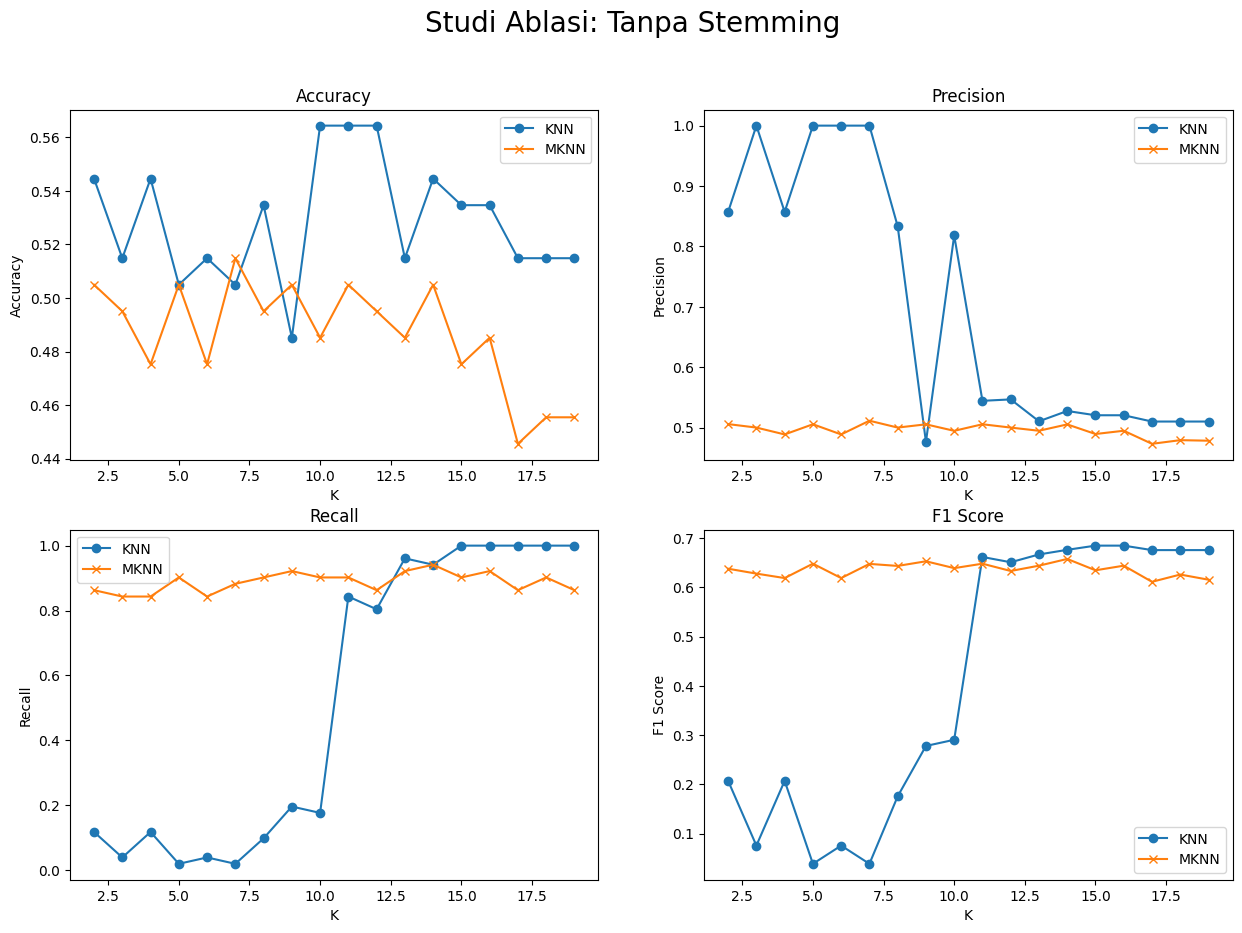

In [84]:
plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title("Accuracy")
plt.plot(knn_acc_dict.keys(), knn_acc_dict.values(), label="KNN", marker="o")
plt.plot(mknn_acc_dict.keys(), mknn_acc_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Precision")
plt.plot(knn_precision_dict.keys(),
         knn_precision_dict.values(), label="KNN", marker="o")
plt.plot(mknn_precision_dict.keys(),
         mknn_precision_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Recall")
plt.plot(knn_recall_dict.keys(), knn_recall_dict.values(),
         label="KNN", marker="o")
plt.plot(mknn_recall_dict.keys(), mknn_recall_dict.values(),
         label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("F1 Score")
plt.plot(knn_f1_score_dict.keys(),
         knn_f1_score_dict.values(), label="KNN", marker="o")
plt.plot(mknn_f1_score_dict.keys(),
         mknn_f1_score_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("F1 Score")
plt.legend()

plt.suptitle("Studi Ablasi: Tanpa Stemming", fontsize=20)
plt.show()

In [85]:
best_f1_score_knn = np.argmax(list(knn_f1_score_dict.values())) + 2
best_f1_score_mknn = np.argmax(list(mknn_f1_score_dict.values())) + 2
best_acc_knn = np.argmax(list(knn_acc_dict.values())) + 2
best_acc_mknn = np.argmax(list(mknn_acc_dict.values())) + 2
best_precision_knn = np.argmax(list(knn_precision_dict.values())) + 2
best_precision_mknn = np.argmax(list(mknn_precision_dict.values())) + 2
best_recall_knn = np.argmax(list(knn_recall_dict.values())) + 2
best_recall_mknn = np.argmax(list(mknn_recall_dict.values())) + 2

pd.DataFrame({
    "metrics": ["F1 Score", "Accuracy", "Precision", "Recall"],
    "KNN": [
            (knn_f1_score_dict[best_f1_score_knn], best_f1_score_knn),
            (knn_acc_dict[best_acc_knn], best_acc_knn),
            (knn_precision_dict[best_precision_knn], best_precision_knn),
            (knn_recall_dict[best_recall_knn], best_recall_knn)
    ],
    "MKNN": [
        (mknn_f1_score_dict[best_f1_score_mknn], best_f1_score_mknn),
        (mknn_acc_dict[best_acc_mknn], best_acc_mknn),
        (mknn_precision_dict[best_precision_mknn], best_precision_mknn),
        (mknn_recall_dict[best_recall_mknn], best_recall_mknn)
    ]
})

,metrics,KNN,MKNN
0,F1 Score,"(0.6845637583892618, 15)","(0.6575342465753425, 14)"
1,Accuracy,"(0.5643564356435643, 10)","(0.5148514851485149, 7)"
2,Precision,"(1.0, 3)","(0.5113636363636364, 7)"
3,Recall,"(1.0, 15)","(0.9411764705882353, 14)"
